# Colab Start Section

Step 1 is to upload a copy of your private key. I am assuming your private key is named id_ed25519. If that isn't the case, you'll have to make manual changes.

In [25]:
# Change these of course to what is your email and your GitHub username
EMAIL = "pauleanderson@gmail.com"
USERNAME = "instructor"

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
%%bash -s "$EMAIL" "$USERNAME"

rm -rf /root/.ssh/*
mkdir /root/.ssh

mv id_ed25519 /root/.ssh/

chmod 600 /root/.ssh/id_ed25519

git config --global user.email "$1"
git config --global user.name "$2"

In [2]:
%%bash -s "$USERNAME"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

git clone git@github.com:anderson-fall-2024/csc-448-$1.git

UsageError: Cell magic `%%shell` not found.


# Topic 3 - Genome Assembly
## Graph Algorithms
Material and embedded exercises.

Motivation and some exercises are variations on those available in Bioinformatics Algorithms: An Active-Learning Approach by Phillip Compeau & Pavel Pevzner.

## Learning Outcomes
* Understand genome assembly bioinformatics motivation
* Apply, analyze, and evaluate genome sequence alignment graph based algorithms

In [26]:
#### NO NEED TO EDIT ####
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,f"csc-448-{USERNAME}")
sys.path.insert(0,"..")

from py448 import Topic3_helper

#### NO NEED TO EDIT ####

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# History and motivation

## Why do we sequence different species?

<table>
    <tr>
                <td><img src="https://www.akcchf.org/assets/images/Dog-Genome-Nature.jpg"></td>
                <td><img src="http://www.scienceagainstevolution.org/images/v10i1g1.jpg" width=300></td>
                <td><img src="https://www.ncbi.nlm.nih.gov/genome/guide/bee/cover_nature.jpg"></td>
    </tr>
    </table>
Many applications in medicine, agriculture, biotechnology, etc begin with a sequenced and annotated genome.

## Brief History of Genome Sequencing
* 1977 - Walter Gilbert and Frederick Sanger develop independent DNA sequencing methods.
* 1980 - They share the Nobel Prize.
* Sequencing methods were too expensive ($3 billion to sequence the human genome)

## The Race to Sequence the Human Genome
* 1990 - The public Human Genome Project, headed by Francis Collins, aims to sequence the human genome by 2005.
* 1997 - Craig Venter founds Celera Genomics, a private firm with the same goal :)
* Genome become available 5 years early in 2000

# Exploding Newspapers

## Consider a silly example
<img src="http://bioinformaticsalgorithms.com/images/Assembly/newspaper_blowup.png">

"Imagine that we stack a hundred copies of the June 27, 2000 edition of the New York Times on a pile of dynamite, and then we light the fuse. We ask you to further suspend your disbelief and assume that the newspapers are not all incinerated but instead explode cartoonishly into smoldering pieces of confetti. How could we use the tiny snippets of newspaper to figure out what the news was on June 27, 2000? We will call this crazy conundrum the Newspaper Problem." - Bioinformatics Chapter 3

<img src="http://bioinformaticsalgorithms.com/images/Assembly/overlapping_newspaper.png" width=400>

Use overlapping shreds of paper to figure out the news.

"Fine, you ask, but what do exploding newspapers have to do with biology? Determining the order of nucleotides in a genome, or genome sequencing, presents a fundamental task in bioinformatics. Genomes vary in length; your own genome is roughly 3 billion nucleotides long, whereas the genome of Amoeba dubia, an amorphous unicellular organism, is approximately 200 times longer! This unicellular organism competes with the rare Japanese flower Paris japonica for the title of species with the longest genome." - Bioinformatics Algorithms, Chapter 3.

## Traditional Method for Genome Sequencing

<img src="http://bioinformaticsalgorithms.com/images/Assembly/sequencing_overview.png">

## What makes genome sequencing difficult?
* Modern sequencing machines cannot read an entire genome one nucleotide at a time from beginning to end (like we read a book)
* They can only shred the genome and generate short  reads (though we can now mix longer reads with these shorter reads)
* The genome assembly is not the same as a jigsaw puzzle: we must use overlapping reads to reconstruct the genome, a  giant overlap puzzle!

## Into the language of computer scientists: String Reconstruction Problem

**Exercise 1** String composition problem: Generate the k-mer composition of a string.
    
Input: An integer $k$ and a string $text$.

Output: The lexicographic ordered collection of all k-mer substrings in text (including repeated k-mers) ``composition(k,text)``, where the k-mers are arranged in lexicographic order.

Example: ``composition(3,TATGGGGTGC)`` => [ATG, GGG, GGG, GGT, GTG, TAT, TGC, TGG]. Notice how there are two entries for GGG, so we keep duplicates.

Learning objective: Build up the skills and vocabulary we need to solve the reconstruction problem.

In [27]:
r = Topic3_helper.composition(3,"TATGGGGTGC")
r

['ATG', 'GGG', 'GGG', 'GGT', 'GTG', 'TAT', 'TGC', 'TGG']

Well that's great and pretty straightfoward, but we need to solve the inverse problem...

**String Reconstruction Problem:** Reconstruct a string from its k-mer composition.

Input: An integer $k$ and a collection ``patterns`` of $k$-mers

Output: A string ``text`` with $k$-mer composition equal to ``patterns`` if such a string exists.

### Easy string reconstruction problem first
Consider ``patterns`` = [AAT ATG GTT TAA TGT]

Most straightfoward way to solve this is to "connect" a pair of $k$-mers if they overlap in $k$-1 symbols. Where should we start? Let's start with ``TAA`` because there is no 3-mer ending in ``TA``. The next $k$-mer has to be ``AAT`` because it is the only one that satisfies. We can continue with this pattern easily for this example:
<pre>
TAA    
 AAT   
  ATG  
   TGT 
    GTT
TAATGTT
</pre>
Nice! We did it, so time to move on to another chapter...

### A harder string reconstruction problem

AAT  ATG  ATG  ATG  CAT  CCA  GAT  GCC  GGA  GGG  GTT  TAA  TGC  TGG  TGT

Let's start with ``TAA`` again:
<pre>
TAA  
 AAT 
  ATG
</pre>
So far so good! Let's try to continue. ``ATG`` can be extended by either ``TGC`` or ``TGG`` or ``TGT``. How do we choose? In other words, how good are you at chess because we need to be able to look ahead. For now, let's choose ``TGT``.

After we choose ``TGT`` our only choose is ``GTT`` so we get:
<pre>
TAA   
 AAT  
  ATG 
   TGT
    GTT
</pre>
But we are now stuck! There is nothing that matches :(

If you are good at looking ahead you could have extended ``ATG`` by ``TGC`` instead.


If we make that change, then we obtain the following assembly:
<pre>
TAA             
 AAT            
  ATG           
   TGC          
    GCC         
     CCA        
      CAT       
       ATG      
        TGG     
         GGA    
          GAT   
           ATG  
            TGT 
             GTT
TAATGCCATGGATGTT
</pre>

## So what was the problem?
Repeats complicate genome assembly!

Our previous problem came from the fact that ``ATG`` is repeated three times which causes us to have the three choices by which to extend ``ATG``. This doesn't pose too much of a problem for small examples, but consider having this happen when we have millions of reads!

## Seven Bridge of Konigsberg

**A resident asks:** Can I set out from my home and cross each bridge once and return home at the end?

Since you know a graph algorithm is coming, how would you represent the above as a graph?

Answer: colors as nodes or vertices and bridges as edges.

In comes the father of graph theory: Leonhard Euler. 

Graphs have edges and vertices. 

This is not a graph today:

<img src="https://datavizproject.com/wp-content/uploads/types/Line-Graph.png" width=400>

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnbt.2023/MediaObjects/41587_2011_Article_BFnbt2023_Fig1_HTML.gif">

**Hamiltonian Paths and Cycles:**

> Hamiltonian path is a path in an undirected or directed graph that visits each vertex exactly once. A Hamiltonian cycle is a Hamiltonian path that is a cycle. Determining whether such paths and cycles exist in graphs is the Hamiltonian path problem, which is NP-complete. - https://en.wikipedia.org/wiki/Hamiltonian_path

**How does this relate to bioinformatics?**

For years bioinformaticians came up with heuristic/approximate algorithms for finding Hamiltonian paths and cycles in order to perform genome assembly. But it is a NP-complete problem.

**After moderate but hard won success the field realized that there was another way...**

And that is where are Bridges of Konigsberg comes into play.

A **Eulerian cycle** is a cycle that visits each edge once but does not matter how many times a vertices or edge is visited.

Big difference is that you can visit a vertices more than once. This seemingly small difference has a dramatic affect on the computability of genome assembly.

The way Euler came up with an algorithm to determine if a Eulerian cycle exists, he came up with a method for finding them. 

## String Reconstruction: A reverse approach/order from the book
The book builds up from walking overlap graphs to an *Algorithm for Finding Eulerian Cycles* (wait what are those words!).

We are going to work our way backwards because it is a good thing to have different complementary approaches. Please please read the book and listen to the textbook online lectures.

Our big goal is the following...

**Solve the string reconstruction problem** using the algorithm for finding Eulerian Cycles. Our approach is as follows:
<pre>
def string_reconstruction(patterns):
    dB = de_bruijn(patterns)
    path = eulerian_path(dB)
    text = path_to_genome(path)
    return text
</pre>

## Constructing de Bruijn graphs from $k$-mer composition
Given a collection of $k$-mers Patterns, the nodes of de_bruijn(k,patterns) are simply all unique (k−1)-mers occurring as a prefix or suffix in Patterns. For example, say we are given the following collection of 3-mers:
<pre>
AAT   ATG   ATG   ATG    CAT   CCA   GAT   GCC   GGA   GGG   GTT   TAA   TGC   TGG   TGT
</pre>
Then the set of eleven unique 2-mers is:
<pre>
AA   AT   CA   CC   GA   GC   GG   GT   TA   TG   TT
</pre>

For every $k$-mer in ``patterns`` we will connect its prefix node to its suffix node by a directed edge in order to produce our final graph.

<img src="http://bioinformaticsalgorithms.com/images/Assembly/debruijn_graph_alternate_rendering.png">

**Exercise 2** Construct the de Bruijn graph from a set of k-mers.

Input: a collection of $k$-mers ``patterns``.

Output: NetworkX directed graph that corresponds to the adjacency list of the de Bruijn graph. 

Now that you know how to use ``networkx``... use it to make your life easier for representing your graph.

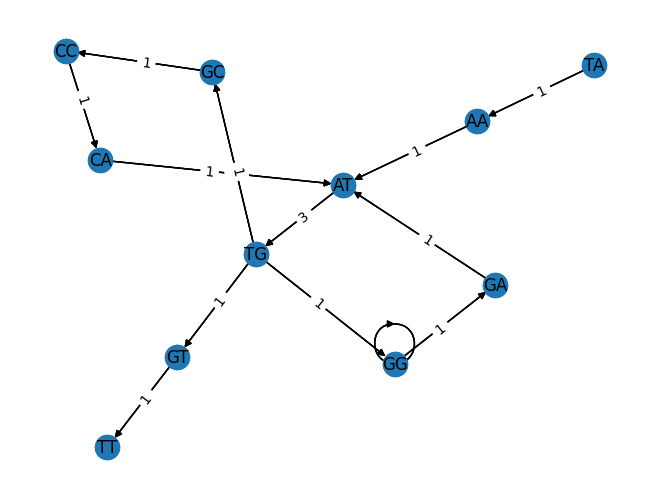

In [28]:
dB = Topic3_helper.de_bruijn(["AAT","ATG","ATG","ATG","CAT","CCA","GAT","GCC","GGA","GGG","GTT","TAA","TGC","TGG","TGT"])
Topic3_helper.show(dB)

In [29]:
Topic3_helper.to_adj(dB)

,AA,AT,TG,CA,CC,GA,GC,GG,GT,TT,TA
AA,0,1,0,0,0,0,0,0,0,0,0
AT,0,0,3,0,0,0,0,0,0,0,0
TG,0,0,0,0,0,0,1,1,1,0,0
CA,0,1,0,0,0,0,0,0,0,0,0
CC,0,0,0,1,0,0,0,0,0,0,0
GA,0,1,0,0,0,0,0,0,0,0,0
GC,0,0,0,0,1,0,0,0,0,0,0
GG,0,0,0,0,0,1,0,1,0,0,0
GT,0,0,0,0,0,0,0,0,0,1,0
TT,0,0,0,0,0,0,0,0,0,0,0


We now have step 1 completed. The next step is to find the Eulerian path, but we will start by talking about and finding Eulerian cycles. More undefined words! Don't forget. For a different bottom up approach (we are taking top down in this lab), then see the textbook. 

A Eulerian path is a path in a graph traversing each edge of a graph exactly once. A cycle that traverses each edge of a graph exactly once is called an Eulerian cycle.

The book works in a lot more detail, but I will boil it down to what I view are the essentials.

If we assume an arbitrary directed graph is balanced (in-degree of each node is equal to out-degree) and it is strongly connected
* Then we can find the Eulerian cycle by just walking around! We just need to make sure we always leave out of a different edge.


**Exercise 3** Given a Eulerian directed graph, find the Eulerian cycle.

Given: An Eulerian directed graph, in the form of a MultiDiGraph networkx object.

Return: An Eulerian cycle in this graph returned as a list.

[0, 3, 2, 6, 8, 7, 9, 6, 5, 4, 2, 1, 0]
[6, 5, 4, 2, 1, 0, 3, 2, 6, 8, 7, 9, 6]


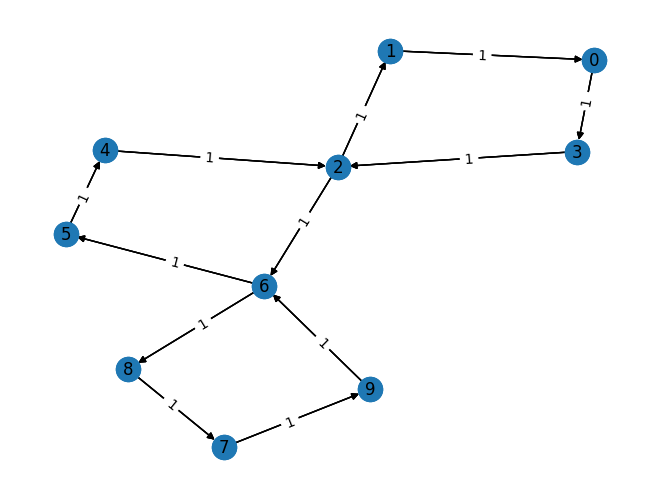

In [30]:
import networkx as nx
    
G = nx.MultiDiGraph()
G.add_edge(0,3)
G.add_edge(1,0)
G.add_edge(2,1)
G.add_edge(2,6)
G.add_edge(3,2)
G.add_edge(4,2)
G.add_edge(5,4)
G.add_edge(6,5)
G.add_edge(6,8)
G.add_edge(7,9)
G.add_edge(8,7)
G.add_edge(9,6)

Topic3_helper.show(G)
print(Topic3_helper.eulerian_cycle(G))


print(Topic3_helper.eulerian_cycle(G,start=6)) # Should also result in a shifted but equivalent answer. 
# If your code isn't working, please carefully read the section on the ant moving around the graph and getting stuck :)

## Eulerian path
Consider the following graph that does not contain a Eulerian cycle.

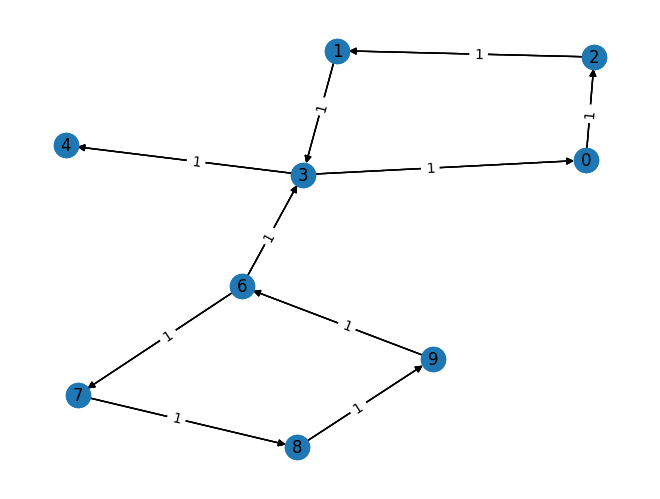

In [31]:
G2 = nx.MultiDiGraph()
G2.add_edge(0,2);G2.add_edge(1,3);G2.add_edge(2,1);G2.add_edge(3,0);G2.add_edge(3,4);G2.add_edge(6,3);G2.add_edge(6,7);G2.add_edge(7,8);G2.add_edge(8,9);G2.add_edge(9,6)
Topic3_helper.show(G2)

Consider the following function that finds the in and out degree of every node.

In [32]:
Topic3_helper.calc_in_out(G2)

,in,out
0,1,1
1,1,1
2,1,1
3,2,2
4,1,0
6,1,2
7,1,1
8,1,1
9,1,1


Is there "nearly" a cycle? If so, how would you find it? What two nodes would you connect?

**Exercise 4** Given a Eulerian directed graph, find the Eulerian path.

Given: An Eulerian directed graph, in the form of a MultiDiGraph networkx object.

Return: An Eulerian cycle in this graph returned as a list.

Hint: Can you find the correct starting node from the output of ``in_out``?

In [33]:
Topic3_helper.eulerian_path(G2)

[6, 7, 8, 9, 6, 3, 0, 2, 1, 3, 4]

We can finally put everything together!

**Exercise 5:** Reconstruct a string from its k-mer composition.

Given: Given a list of $k$-mers patterns.

Return: A string ``text`` with $k$-mer composition equal to patterns.

In [34]:
kmers = ["CTTA","ACCA","TACC","GGCT","GCTT","TTAC"]
Topic3_helper.reconstruct(kmers)

'GGCTTACCA'

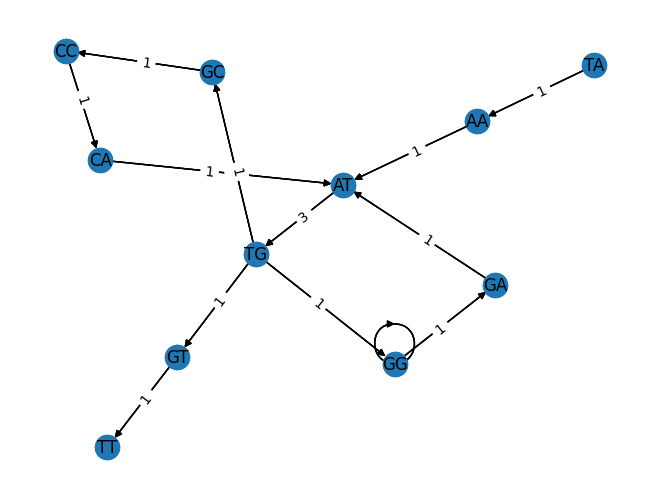

In [35]:
kmers = ['AAT','ATG','ATG','ATG','CAT','CCA','GAT','GCC','GGA','GGG','GTT','TAA','TGC','TGG','TGT']
Topic3_helper.de_bruijn(kmers)
Topic3_helper.show(dB)

In [36]:
# Don't forget to push!

# Test your code

In [38]:
%%bash -s "$USERNAME"

cd csc-448-$1/tests
pytest test_Topic3.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-8.3.3, pluggy-1.5.0
rootdir: /Users/pander14/GitHub/csc-448-instructor/tests
plugins: anyio-4.6.0
collected 5 items

test_Topic3.py .....                                                     [100%]

============================== 5 passed in 2.16s ===============================


# Colab End Section - Submit your code

In [ ]:
%%bash -s "$USERNAME"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

cd csc-448-$1
./command_line_sync.sh